### 1. Воздушные перевозки

Скачайте и распакуте следующий [архив](http://stat-computing.org/dataexpo/2009/2008.csv.bz2). Описание полей таблицы дано [здесь](http://www.transtats.bts.gov/Fields.asp?Table_ID=236).

Данные должны содержать перелеты воздушных судов в 2008 году (вероятно в США)

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

avia_df = pd.read_csv('../data/2008.csv')

In [2]:
print(avia_df.columns.values)

['Year' 'Month' 'DayofMonth' 'DayOfWeek' 'DepTime' 'CRSDepTime' 'ArrTime'
 'CRSArrTime' 'UniqueCarrier' 'FlightNum' 'TailNum' 'ActualElapsedTime'
 'CRSElapsedTime' 'AirTime' 'ArrDelay' 'DepDelay' 'Origin' 'Dest'
 'Distance' 'TaxiIn' 'TaxiOut' 'Cancelled' 'CancellationCode' 'Diverted'
 'CarrierDelay' 'WeatherDelay' 'NASDelay' 'SecurityDelay'
 'LateAircraftDelay']


**Задание 1:** Рассчитать топ-10 массовых перевозчиков.

In [3]:
popularity=avia_df['UniqueCarrier'].value_counts()
most_popular=popularity[:10]
most_popular

WN    1201754
AA     604885
OO     567159
MQ     490693
US     453589
DL     451931
UA     449515
XE     374510
NW     347652
CO     298455
Name: UniqueCarrier, dtype: int64

Unique Carrier Code.
When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.

**Задание 2:** Построить распределение причин отмены рейсов

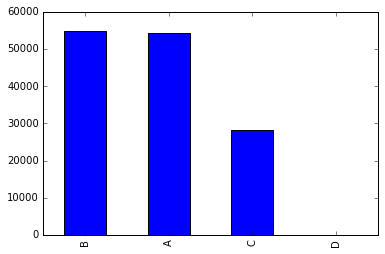

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
avia_df['CancellationCode'].value_counts().plot(kind='bar')

$A$ - Carrier, $B$ - Weather, $C$ - National Air System, $D$ - Security.

**Задание 3:** Найти самый популярный маршрут, выдать статистику по данному маршруту.

In [5]:
grouped = avia_df.groupby(['Origin', 'Dest'])
popularity_path=grouped.size().sort_values(ascending=False) #size считает размер каждой из групп, отсортированных по месту вылета и прилета
popularity_path[:1]

Origin  Dest
SFO     LAX     13788
dtype: int64

In [6]:
grouped.get_group(('SFO', 'LAX')).describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,13788,13788.000000,13788.000000,13788.000000,13299.000000,13788.000000,13286.000000,13788.000000,13788.000000,13285.000000,...,13788,13286.000000,13299.000000,13788.000000,13788.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,2008,6.337322,15.730418,3.862997,1371.032408,1356.596388,1481.378820,1493.550116,1862.825573,82.417840,...,337,9.912163,17.273554,0.035466,0.001015,9.689688,0.360280,7.630808,0.026416,42.157225
std,0,3.358147,8.791381,1.973866,489.328348,472.940974,502.009856,473.465680,1999.167552,10.184247,...,0,5.120369,7.126813,0.184960,0.031850,27.959199,8.216006,16.685259,1.009160,46.774688
min,2008,1.000000,1.000000,1.000000,3.000000,540.000000,1.000000,5.000000,4.000000,58.000000,...,337,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008,3.000000,8.000000,2.000000,941.000000,945.000000,1054.000000,1110.000000,817.000000,75.000000,...,337,7.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
50%,2008,6.000000,16.000000,4.000000,1355.000000,1315.000000,1507.000000,1443.000000,1153.000000,81.000000,...,337,9.000000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,28.000000
75%,2008,9.000000,23.000000,5.000000,1809.000000,1756.000000,1919.000000,1920.000000,1957.000000,88.000000,...,337,12.000000,20.000000,0.000000,0.000000,7.000000,0.000000,11.000000,0.000000,64.000000
max,2008,12.000000,31.000000,7.000000,2400.000000,2240.000000,2400.000000,2359.000000,7815.000000,196.000000,...,337,106.000000,84.000000,1.000000,1.000000,339.000000,406.000000,401.000000,54.000000,373.000000


**Задание 4:** Найти топ-5 рейсов по каждому из типов delay. Каким перевозчикам они принадлежат?

In [16]:
avia_df[avia_df['FlightNum'] == 7417]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
132376,2008,1,5,6,1723,1730,1825,1834,YV,7417,...,4,23,0,NaN,0,NaN,NaN,NaN,NaN,NaN
137437,2008,1,12,6,1644,1655,1806,1818,YV,7417,...,5,28,0,NaN,0,NaN,NaN,NaN,NaN,NaN
137703,2008,1,12,6,1844,1900,1950,2021,YV,7417,...,5,8,0,NaN,0,NaN,NaN,NaN,NaN,NaN
142422,2008,1,19,6,1655,1655,1818,1818,YV,7417,...,12,26,0,NaN,0,NaN,NaN,NaN,NaN,NaN
142694,2008,1,19,6,1910,1900,2032,2021,YV,7417,...,11,22,0,NaN,0,NaN,NaN,NaN,NaN,NaN
147378,2008,1,26,6,1725,1655,1834,1818,YV,7417,...,5,16,0,NaN,0,0,0,0,0,16
147648,2008,1,26,6,1900,1900,2020,2021,YV,7417,...,7,23,0,NaN,0,NaN,NaN,NaN,NaN,NaN
728007,2008,2,2,6,NaN,1655,NaN,1818,YV,7417,...,NaN,NaN,1,A,0,NaN,NaN,NaN,NaN,NaN
728277,2008,2,2,6,NaN,1900,NaN,2021,YV,7417,...,NaN,NaN,1,A,0,NaN,NaN,NaN,NaN,NaN
733029,2008,2,9,6,1649,1655,1803,1818,YV,7417,...,8,21,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [5]:
#рассмотрим только те рейсы, про которые нам известна информация 
avia_df_Delays = avia_df.dropna(subset = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'])

avia_df['OverallDelay'] = avia_df['CarrierDelay'] + avia_df['WeatherDelay'] + avia_df['NASDelay'] + avia_df['SecurityDelay'] + avia_df['LateAircraftDelay']

best_CarrierDelay = avia_df_Delays.groupby('FlightNum')['OverallDelay']\
.sum().sort_values().iloc[0:5]
for i in range(0,5):
    print(avia_df_Delays[avia_df_Delays['FlightNum'] == best_CarrierDelay.index[i]]\
          [['UniqueCarrier', 'FlightNum', 'OverallDelay']])

        UniqueCarrier  FlightNum  OverallDelay
1976848            OO       6204            15
        UniqueCarrier  FlightNum  OverallDelay
4995147            OO       6321            15
       UniqueCarrier  FlightNum  OverallDelay
147378            YV       7417            16
        UniqueCarrier  FlightNum  OverallDelay
6613905            OH       6874            16
       UniqueCarrier  FlightNum  OverallDelay
931933            F9       8403            17


**Задание 5:** Определить, как распределено количество рейсов от времени дня?

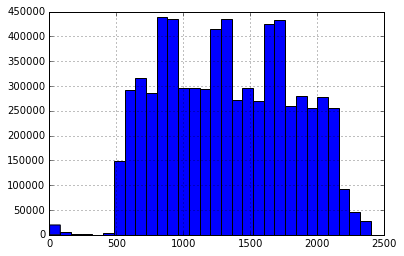

In [15]:
avia_df['DepTime'].hist(bins=30)
plt.show()

**Задание 6:** Определить "сезонность" во временных рядах по количеству вылетов на каждый день.

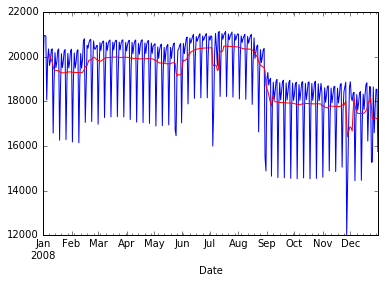

In [26]:
avia_df['Date'] = pd.to_datetime(avia_df.Year*10000 + 
                                 avia_df.Month*100 + 
                                 avia_df.DayofMonth, 
                                 format='%Y%m%d')
num_flights_by_date = avia_df.groupby('Date')['FlightNum'].agg('count')
num_flights_by_date.plot()
plt.lines = pd.rolling_mean(num_flights_by_date, 7).plot(color = 'r', linewidth = 1)

### 2. Продолжаем изучать Pandas

Ввиду ограниченности времени, мы не успеваем рассмотреть всё на семинарах. Поэтому часть работы ложится на вас..

Загрузите две csv таблицы [отсюда](https://github.com/emorisse/FBI-Hate-Crime-Statistics) и импортируйте через Pandas. В них содержатся агрегированные данные по различным организациям\городам США, содержащие количество обращений по тем или иным случаям нарушения закона. В одной таблице (table13.csv) перечислены управления, которые сообщали об этих случаях, в другой - которые не сообщали.

**Задание 1:** Изучите документации для методов `unique_values`, `isin`. С помощью этой функции, определите, содержатся ли в двух таблицах одни и те же штаты.

In [38]:
# Your code here..from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

table13_df = pd.read_csv('../FBI-Hate-Crime-Statistics-master/2013/table13.csv', thousands=',')
table14_df = pd.read_csv('../FBI-Hate-Crime-Statistics-master/2013/table14.csv', thousands=',')
table13_df.columns.values

array(['State', 'Agency type', 'Agency name', 'Race', 'Religion',
       'Sexual orientation', 'Ethnicity', 'Disability', 'Gender',
       'Gender Identity', '1st quarter', '2nd quarter', '3rd quarter',
       '4th quarter', 'Population'], dtype=object)

In [39]:
table14_df.columns.values

array(['State', 'Agency Type', 'Agency Name', 'Q1', 'Q2', 'Q3', 'Q4',
       'Population'], dtype=object)

In [42]:
#программа выводит True если находит совпадения в столбцах State.
result_1 = table13_df['State'].isin(table14_df['State'])
#отсортируем результаты
result_1.sort()
result_1.head(10)

959     False
960     False
961     False
962     False
958     False
371     False
372     False
1223     True
1222     True
1221     True
Name: State, dtype: bool

Видно, что есть 7 несовпадений, то есть 7 штатов находятся только в одной таблице. Однако стоит обратить внимание, чт большинство присутствует в обоих источниках данных.

**Задание 2:** Изучите документации для методов `append`, `merge` и `concat`. Совместите две таблицы в одну.

In [43]:
table13_df.head(10)

,State,Agency type,Agency name,Race,Religion,Sexual orientation,Ethnicity,Disability,Gender,Gender Identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
0,Alabama,Cities,Florence,2,0,0,0,0,0,0,0,1,0,1,39481
1,Alabama,Cities,Hoover,0,0,1,0,0,0,0,0,1,0,0,84139
2,Alabama,Cities,Prattville,2,0,0,0,0,0,0,1,0,1,0,35154
3,Alabama,Cities,Tuscaloosa,1,0,0,0,0,0,0,0,0,1,0,94126
4,Alaska,Cities,Anchorage,8,0,0,0,0,0,0,2,3,3,0,299455
5,Arizona,Cities,Apache Junction,1,0,0,0,0,0,0,1,0,0,NaN,36626
6,Arizona,Cities,Avondale,4,0,0,1,0,0,0,1,1,3,0,78905
7,Arizona,Cities,Eagar,0,0,0,1,0,0,0,0,1,0,0,5034
8,Arizona,Cities,El Mirage,1,0,0,0,0,0,0,0,0,1,0,32837
9,Arizona,Cities,Gilbert,1,0,0,0,0,0,0,1,0,0,0,225232


In [44]:
table14_df.head(10)

,State,Agency Type,Agency Name,Q1,Q2,Q3,Q4,Population
0,Alabama,Cities,Ashford,0,0,0,0,2177
1,Alabama,Cities,Ashland,0,0,0,0,1926
2,Alabama,Cities,Auburn,0,0,0,0,57970
3,Alabama,Cities,Berry,NaN,0,NaN,NaN,1124
4,Alabama,Cities,Childersburg,0,0,0,0,5111
5,Alabama,Cities,Courtland,0,0,0,0,607
6,Alabama,Cities,Demopolis,0,0,0,0,7240
7,Alabama,Cities,Eclectic,0,0,0,0,1015
8,Alabama,Cities,Enterprise,0,0,0,0,28145
9,Alabama,Cities,Eutaw,0,0,0,0,2871


In [45]:
# некоторые имена столбцов отличаются друг от друга. Исправим это. 
table14_df=table14_df.rename(columns={'Q1' : '1st quarter', 'Q2' : '2nd quarter', 'Q3' : '3rd quarter', 'Q4' : '4th quarter',\
                           'Agency Type' : 'Agency type', 'Agency Name' : 'Agency name'})

uni_df = table13_df.append(table14_df, ignore_index=True)
uni_df = uni_df[['State', 'Agency type', 'Agency name', 'Race', 'Religion',
       'Sexual orientation', 'Ethnicity', 'Disability', 'Gender',
       'Gender Identity', '1st quarter', '2nd quarter', '3rd quarter',
       '4th quarter', 'Population']]
uni_df.head(10)

,State,Agency type,Agency name,Race,Religion,Sexual orientation,Ethnicity,Disability,Gender,Gender Identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
0,Alabama,Cities,Florence,2,0,0,0,0,0,0,0,1,0,1,39481
1,Alabama,Cities,Hoover,0,0,1,0,0,0,0,0,1,0,0,84139
2,Alabama,Cities,Prattville,2,0,0,0,0,0,0,1,0,1,0,35154
3,Alabama,Cities,Tuscaloosa,1,0,0,0,0,0,0,0,0,1,0,94126
4,Alaska,Cities,Anchorage,8,0,0,0,0,0,0,2,3,3,0,299455
5,Arizona,Cities,Apache Junction,1,0,0,0,0,0,0,1,0,0,NaN,36626
6,Arizona,Cities,Avondale,4,0,0,1,0,0,0,1,1,3,0,78905
7,Arizona,Cities,Eagar,0,0,0,1,0,0,0,0,1,0,0,5034
8,Arizona,Cities,El Mirage,1,0,0,0,0,0,0,0,0,1,0,32837
9,Arizona,Cities,Gilbert,1,0,0,0,0,0,0,1,0,0,0,225232


**Задание 3:** Изучите документации для методов `drop_dublicates` и `dropna`. Используйте метод `dropna` для очистки большой таблицы от пропусков. Что произошло? Почему? Исправьте таблицы, чтобы получить корректный ответ.

In [47]:
drop_df = uni_df.dropna()
drop_df

,State,Agency type,Agency name,Race,Religion,Sexual orientation,Ethnicity,Disability,Gender,Gender Identity,1st quarter,2nd quarter,3rd quarter,4th quarter,Population
0,Alabama,Cities,Florence,2,0,0,0,0,0,0,0,1,0,1,39481
1,Alabama,Cities,Hoover,0,0,1,0,0,0,0,0,1,0,0,84139
2,Alabama,Cities,Prattville,2,0,0,0,0,0,0,1,0,1,0,35154
3,Alabama,Cities,Tuscaloosa,1,0,0,0,0,0,0,0,0,1,0,94126
4,Alaska,Cities,Anchorage,8,0,0,0,0,0,0,2,3,3,0,299455
6,Arizona,Cities,Avondale,4,0,0,1,0,0,0,1,1,3,0,78905
7,Arizona,Cities,Eagar,0,0,0,1,0,0,0,0,1,0,0,5034
8,Arizona,Cities,El Mirage,1,0,0,0,0,0,0,0,0,1,0,32837
9,Arizona,Cities,Gilbert,1,0,0,0,0,0,0,1,0,0,0,225232
10,Arizona,Cities,Glendale,2,3,1,1,0,0,0,2,0,3,2,234006


dropna удалил все строчки, в которых встречал NaN. Так как таблица была отредактирована еще во втором пункте данной задачи, то остались только те строки, про которые нам известны все даные.
Очевидно, что в данной таблице не будет данных по table14, так как там неизвестно число зафиксированных обращений по нарушению закона.

**Задание 4:** Изучите документации для методов `set_index`, `reset_index` и `pivot_table`. Проиндексируйте общую таблицу по переменным State и Agency Type (одновременно). У вас должен появиться *мультииндекс*.

In [48]:
multi_df = drop_df.set_index(['State', 'Agency type'])
multi_df

Agency name  \
State         Agency type                                                       
Alabama       Cities                                                 Florence   
              Cities                                                   Hoover   
              Cities                                               Prattville   
              Cities                                               Tuscaloosa   
Alaska        Cities                                                Anchorage   
Arizona       Cities                                                 Avondale   
              Cities                                                    Eagar   
              Cities                                                El Mirage   
              Cities                                                  Gilbert   
              Cities                                                 Glendale   
              Cities                                                 Maricopa   
              Cities                                                     Mesa   
              Cities                                                 Prescott   
              Cities                                               Scottsdale   
              Cities                                                    Tempe   
              Cities                                                   Tucson   
              Cities                                                     Yuma   
              Universities and Colleges           Northern Arizona University   
              Universities and Colleges                 University of Arizona   
Arkansas      Cities                                              Bentonville   
              Cities                                               Berryville   
              Cities                                                    Cabot   
              Cities                                                  England   
              Cities                                            Fairfield Bay   
              Cities                                               Fort Smith   
              Cities                                                   Gurdon   
              Cities                                                   Marion   
              Cities                                        North Little Rock   
              Cities                                               Pine Bluff   
              Cities                                                   Rogers   
...                                                                       ...   
Washington    Universities and Colleges  Washington State University, Pullman   
              Universities and Colleges         Western Washington University   
West_Virginia Cities                                            Barboursville   
              Cities                                                  Beckley   
              Cities                                               Buckhannon   
              Cities                                               Charleston   
              Cities                                                   Dunbar   
              Cities                                                 Fairmont   
              Cities                                               Huntington   
              Cities                                              Martinsburg   
              Cities                                               Morgantown   
              Cities                                              Moundsville   
              Cities                                                 Oak Hill   
              Cities                                                Wellsburg   
Wisconsin     Cities                                                   Algoma   
              Cities                                                 Appleton   
              Cities                                               Burlington   
              Ci

**Задание 5:** В Pandas можно идерировать по DataFrame! Ищучите документации для методов `iteritems`, `iterrows`, а так же посмотрите, как можно итерировать по сгруппированным DataFrame'ам. Выделите подтаблицу, состаящую из данных по 3 произвольным штатам и сгруппируйте её по переменным State и Agency Type. С помощью изученных методов (то есть итеративно) выведите суммарную популяцию по каждой паре <Штат>-<Тип>

In [50]:
mini_df = uni_df.loc[uni_df['State'].isin(['Alabama', 'Alaska', 'Wisconsin'])]
grouped_mini = list(mini_df.groupby(['State', 'Agency type']))
for i, grp in grouped_mini:
    print(*i, grp['Population'].sum())

Alabama Cities 1029459.0
Alabama Metropolitan Counties 0.0
Alabama Nonmetropolitan Counties 0.0
Alabama Universities and Colleges 19854.0
Alaska Cities 473880.0
Alaska Other Agencies 0.0
Alaska State Police Agencies 0.0
Alaska Universities and Colleges 26720.0
Wisconsin Cities 3822720.0
Wisconsin Metropolitan Counties 0.0
Wisconsin Nonmetropolitan Counties 0.0
Wisconsin Other Agencies 0.0
Wisconsin State Police Agencies 0.0
Wisconsin Tribal Agencies 0.0
Wisconsin Universites and Colleges 157630.0
Wisconsin Universities and Colleges 8668.0


## 3. Метод градиентного спуска

Напомним суть метода градиентого спуска в контексте задачи линейной регрессии.

Дано описание $n$ объектов по $m$ признакам. Обычно оно выражается в виде матрицы размера $n \times m$: $X = [x^{(i)}_j]^{i=1\dots n}_{j=1\dots m} $.<br\> ($x^{(i)}_j$ означает $j$-ый признак $i$-го объекта) <br\>
Дана зависимая переменная, которая тоже имеет отношение к этим объекам: $y$ - вектор длины $n$.

Наша задача, выявить **линейную** зависимость между признаками в $X$ и значениями в $y$:
$$\hat{y} = X\beta \quad \Leftrightarrow \quad \hat{y}^{(i)} = \beta_0 + \beta_1x^{(i)}_1 + \dots$$

И сделать это так, чтобы квадрат суммы ошибок наших оценок был минимален:
$$ L(\beta) = \frac{1}{2n}(\hat{y} - y)^{\top}(\hat{y} - y) = \frac{1}{2n}(X\beta - y)^{\top}(X\beta - y) \rightarrow \min$$ $$ \Updownarrow $$  $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 + \dots - y^{(i)})^2  \rightarrow \min $$

Значение в $X$ и $y$ нам даны. Нам неизвестны только значения коэффициентов $\beta$.<br\> Соответственно, нужно найти такие значения $\beta$, что функция $L(\beta) \rightarrow \min.$

На семинаре мы выяснили, чему равен градиент функции потерь $L(\beta_0, \beta_1):$
$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)}$$

Иногда проще это записать в виде матриц:
$$ \frac{\partial L}{\partial \beta} = X^\top(X\beta - y)$$


Метод градиентного спуска заключается в итеративном и **одновременном(!!!)** обновлении значений $\beta$ в направлении, противоположному градиенту:
$$ \beta := \beta - \alpha\frac{\partial L}{\partial \beta}$$

**Задача 1:** Загрузите [данные](http://bit.ly/1gIQs6C) по характеристикам автомобилей Honda Accord. Названия столбцов говорят сами за себя.

Составьте матрицу $X$, состоящую из единичного столбца и признака "пробег". <br\>
Составьте вектор $y$ состоящий из стоимости автомобиля.

Если для импорта вы используете `pandas`, то через .values из DataFrame можно получить numpy array.

In [1]:
# Здесь ваш код# Your code here..from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

Honda_df = pd.read_csv('../data/accord_sedan_training.csv')
Honda_df.head(5)

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


In [2]:
matrix = Honda_df.values
type(matrix)

numpy.ndarray

In [3]:
A = Honda_df.as_matrix(['mileage'])
X = np.insert(A, 0, 1, axis = -1)
X = X.view(type=np.matrix)
X.shape

(417, 2)

In [4]:
y = Honda_df.as_matrix(['price'])
y = y.flatten()
y.shape

(417,)

**Задача 2:** Изобразите функционал квадратичной ошибки $L(\beta_0, \beta_1)$ в 3D и его линии уровня

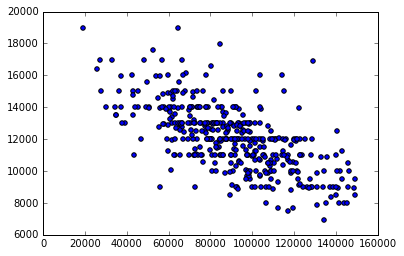

In [5]:
plt.scatter(Honda_df['mileage'], Honda_df['price'])

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize as opt
import sympy
from sympy import symbols, diff

plt.style.use('ggplot')

%matplotlib inline

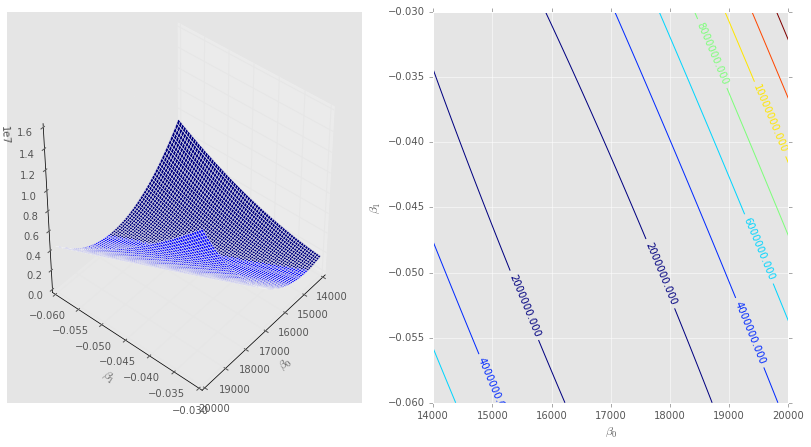

In [34]:
from sympy import *
b0 = Symbol('b0')
b1 = Symbol('b1')
B = np.array([b0, b1])
y1=np.dot(X, B)
deviation = y1 - y 
N = deviation.size
L = 0

for i in range(N):
    L += (deviation[0,i])**2
L = 1/(2*N)*L
    
b_1 = np.linspace(-0.06, -0.03, 700)
b_0 = np.linspace(14000, 20000, 700)
B0, B1 = np.meshgrid(b_0,b_1)
L_beta = lambdify([b0, b1], L)

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(40, 40)
ax.plot_surface(B0, B1, L_beta(B0, B1), alpha = 1,)
# ax.plot_(X, Y, Z)
ax.set_xlabel('$\\beta_{0}$')
ax.set_ylabel('$\\beta_{1}$')

ax = fig.add_subplot(1, 2, 2)
contour = ax.contour(B0, B1, L_beta(B0, B1))
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('$\\beta_{0}$')
ax.set_ylabel('$\\beta_{1}$')

**Задача 3:** Напишите код, реализующий метод градиентного спуска. На вход метод должен принимать исходные данные, максимальное кол-во итераций и коэффициент скорости спуска.

In [35]:
db0 = L.diff(b0)
db1 = L.diff(b1)

dLb0 = lambdify([b0, b1], db0)
dLb1 = lambdify([b0, b1], db1)

#тк у нас две переменные, то введем для них отдельные значения параметров  
iter_max = 10000 # максимальное кол-во итераций
alpha_b0 = 0.1 # скорость спуска
alpha_b1 = 0.0000000001
old_min_b0 = 0
old_min_b1 = 0
temp_min_b0 = 4
temp_min_b1 = 4
precision = 0.001 # требуемая точность
i = 0

while abs(temp_min_b0 - old_min_b0) > precision or abs(temp_min_b1 - old_min_b1) > precision and i<iter_max:
    old_min_b0 = temp_min_b0
    old_min_b1 = temp_min_b1
    move_b0 = dLb0(temp_min_b0, temp_min_b1) * alpha_b0
    move_b1 = dLb1(temp_min_b0, temp_min_b1) * alpha_b1
    temp_min_b0 = old_min_b0 - move_b0
    temp_min_b1 = old_min_b1 - move_b1
    i += 1

**Задача 4:** Выведите полученные значения коэфициентов $\beta$. <br\>Как они интерпретируются?  <br\>Изобразите на одном графике $[y - \text{"пробег"}]$ точки и полученную прямую.

In [36]:
b0 = temp_min_b0
b1 = temp_min_b1
B = np.array([b0, b1])
print(b0, b1)

16761.882659387706 -0.05213273588909508


Получается, что с ростом пробега, цена падает примерно на $\beta_{0}\approx0.05$. 

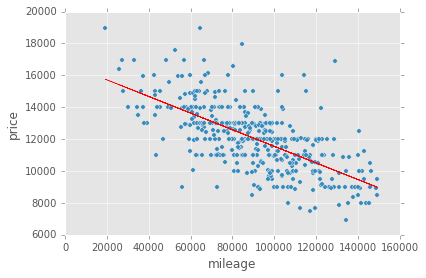

In [37]:
X = np.array(Honda_df.iloc[:,1])[:,np.newaxis]
y = np.array(Honda_df.iloc[:,0])[:,np.newaxis]
points = np.hstack([X, y])
predictions = b1*X + b0
Honda_df.plot(kind='scatter', x='mileage', y='price')
plt.plot(X, predictions, c='red', linewidth=0.5)